In [3]:
import pandas as pd
import numpy as np

# Load the data (have to change the name for each sport
cycling_path = 'clean_data_cycling.csv'
strength_path = 'clean_data_strength.csv'
elyptic_path = 'clean_data_elyptic.csv'
walking_path = 'clean_data_walking.csv'

cycling_data = pd.read_csv(cycling_path)
strength_data = pd.read_csv(strength_path)
elyptic_data = pd.read_csv(elyptic_path)
walking_data = pd.read_csv(walking_path)

In [6]:
data = pd.concat([cycling_data, strength_data, elyptic_data,walking_data], axis=0, ignore_index=True)
data


,time,rotationRateX,rotationRateY,rotationRateZ,gravityX,gravityY,gravityZ,accelerationX,accelerationY,accelerationZ,...,quaternionY,quaternionZ,z_gyro,y_gyro,x_gyro,z_acc,y_acc,x_acc,bpm,sport
0,171829243429,-0.246384,-0.081519,0.110493,0.317334,0.813489,-0.487376,-0.042294,-0.031018,0.024852,...,-0.437900,0.852192,-0.138021,-0.582045,-0.219524,-0.243557,-0.577762,-0.190925,105.0,1
1,171829243434,-0.138480,-0.123311,0.156557,0.319853,0.817145,-0.479550,-0.028440,0.049691,-0.053638,...,-0.442362,0.850672,-0.203224,-0.220469,-0.020842,-0.788626,-0.268524,0.834922,105.0,1
2,171829243439,-0.078834,-0.117711,0.288981,0.324156,0.815928,-0.478733,-0.063689,-0.070124,-0.042721,...,-0.443388,0.851395,-0.172186,-0.185771,0.024884,-0.398124,-0.406848,0.431240,105.0,1
3,171829243444,0.135324,-0.119591,0.278078,0.331465,0.810568,-0.482816,-0.048292,0.014734,-0.036853,...,-0.441038,0.853461,-0.156555,-0.071315,0.144891,-0.001588,-0.409412,-0.190077,105.0,1
4,171829243449,0.171445,-0.084271,0.341000,0.341875,0.801126,-0.491243,0.001311,0.071738,-0.023100,...,-0.435520,0.856728,-0.313300,0.043542,0.165136,0.145781,-0.103795,-0.076771,105.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122756,171845325465,0.011509,0.004987,-0.103949,0.454161,-0.156195,-0.877121,-0.022810,0.011115,-0.014603,...,0.113062,-0.671557,-0.025019,0.051899,-0.045916,0.179155,-0.001606,0.104401,96.0,4
122757,171845325470,0.041038,-0.017271,-0.114505,0.453735,-0.154562,-0.877630,-0.002884,0.017629,-0.013086,...,0.112846,-0.673632,-0.009317,0.145092,-0.061757,-0.094930,0.167722,0.344567,96.0,4
122758,171845325475,0.023868,-0.034400,-0.103798,0.452458,-0.152908,-0.878579,0.018138,0.003280,-0.003455,...,0.112296,-0.675838,0.028126,0.118389,-0.056851,-0.007466,0.066977,0.080784,96.0,4
122759,171845325480,0.006906,-0.042538,-0.078482,0.451025,-0.150765,-0.879685,0.019159,-0.017066,0.006226,...,0.111949,-0.677803,0.029365,0.096701,-0.016461,-0.159239,-0.063177,-0.272097,96.0,4


## Feature Engineering

 ### PCA

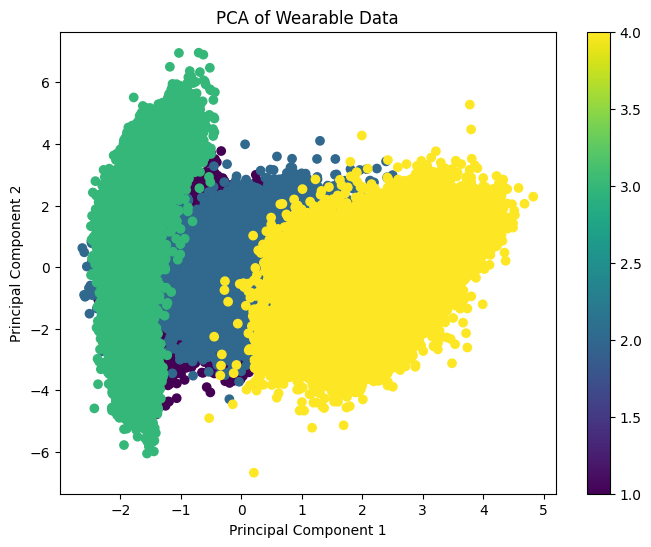

Explained variance ratio: [0.14581548 0.11926783]


In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your dataset


# List of features to be used for PCA
features = ['rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX', 
            'gravityY', 'gravityZ', 'accelerationX', 'accelerationY', 
            'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY', 
            'quaternionZ', 'z_gyro', 'y_gyro', 'x_gyro', 'z_acc', 'y_acc', 
            'x_acc', 'bpm']

# Separating out the features
x = data[features]

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Performing PCA
pca = PCA(n_components=2)  # Adjust n_components as needed
principal_components = pca.fit_transform(x)

# Creating a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])

# Adding the target variable (if any) to the DataFrame
# Assuming the target variable is 'sport'
principal_df = pd.concat([principal_df, data[['sport']]], axis=1)

# Visualizing the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(principal_df['PCA1'], principal_df['PCA2'], c=principal_df['sport'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wearable Data')
plt.colorbar()
plt.savefig('PCA.png') 
plt.show()

# Explained variance
explained_variance = pca.explained_variance_ratio_
print('Explained variance ratio:', explained_variance)


### Mean over windows


In [10]:
# Mean with windows
def mean_features(df, window_size):
    feature_df = pd.DataFrame()
    for col in df.columns:
        if col not in ['time', 'sport']:
            feature_df[col + f'_mean{window_size}'] = df[col].rolling(window=window_size).mean()
    return feature_df

# Example usage
# Assuming df is your DataFrame

window5 = mean_features(data, 5)
window20 = mean_features(data, 20)
window100 = mean_features(data, 100)


### Frequency Features

In [11]:
import pandas as pd
import numpy as np
from scipy.signal import welch
import pandas as pd
import numpy as np
from scipy.signal import welch

def frequency_features(df, window_size, step_size, fs=1.0):
    """
    Extract frequency domain features on a rolling basis.

    Parameters:
    - df: pandas DataFrame with the data
    - window_size: size of each window
    - step_size: step size for rolling computation
    - fs: sampling frequency (default 1.0)

    Returns:
    - feature_df: DataFrame with frequency features for each rolling window
    """
    feature_list = []

    for end in range(window_size, len(df) + 1, step_size):
        window_df = df.iloc[max(0, end - window_size):end]
        feature_dict = {}

        for col in df.columns:
            if col not in ['time', 'seconds_elapsed', 'seconds_elapsed_gyro', 'seconds_elapsed_acc', 'seconds_elapsed_hr']:
                col_data = window_df[col].dropna()
                if len(col_data) > 0:
                    freqs, psd = welch(col_data, fs=fs, nperseg=min(window_size, len(col_data)))
                    dominant_freq = freqs[np.argmax(psd)]
                    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-10)) / np.log2(len(psd))
                    feature_dict[col + '_dominant_freq'] = dominant_freq
                    feature_dict[col + '_spectral_entropy'] = spectral_entropy

        feature_list.append(feature_dict)

    feature_df = pd.DataFrame(feature_list)

    # Repeat the same features for each window
    repeated_features = pd.concat([feature_df] * step_size, ignore_index=True)

    return repeated_features[:len(df)]  # Trim to match the length of the original DataFrame

# Example 
# Assuming df is your DataFrame and you have handled NaNs
window_size = 50  # Example window size
step_size = 100    # Example step size for rolling computation
data = data.dropna()  # Drop rows with NaN values

# Extract rolling frequency features
frequency_features_df = frequency_features(data, window_size, step_size)

# Interpolate features to match the length of the original DataFrame

# Verify the resulting DataFrame
# Extract rolling frequency features
frequency_features_df




,rotationRateX_dominant_freq,rotationRateX_spectral_entropy,rotationRateY_dominant_freq,rotationRateY_spectral_entropy,rotationRateZ_dominant_freq,rotationRateZ_spectral_entropy,gravityX_dominant_freq,gravityX_spectral_entropy,gravityY_dominant_freq,gravityY_spectral_entropy,...,z_acc_dominant_freq,z_acc_spectral_entropy,y_acc_dominant_freq,y_acc_spectral_entropy,x_acc_dominant_freq,x_acc_spectral_entropy,bpm_dominant_freq,bpm_spectral_entropy,sport_dominant_freq,sport_spectral_entropy
0,0.02,1.250353,0.04,1.065136,0.02,0.024231,0.02,0.170653,0.02,0.295288,...,0.22,1.883183,0.12,1.273326,0.20,0.807572,0.00,-0.000000,0.0,-0.0
1,0.10,0.705878,0.02,0.554046,0.04,0.574681,0.02,0.025264,0.02,0.007683,...,0.02,1.822456,0.02,0.463522,0.02,0.556914,0.02,0.485121,0.0,-0.0
2,0.06,-0.033529,0.16,1.871516,0.06,-0.287566,0.02,0.198046,0.06,0.092824,...,0.06,-683.788184,0.06,-281.356606,0.16,-18.664952,0.00,-0.000000,0.0,-0.0
3,0.08,-3.487442,0.40,1.871945,0.06,-5.970553,0.06,0.146250,0.02,0.335014,...,0.06,-1161.631009,0.12,-242.543217,0.18,-51.783547,0.00,-0.000000,0.0,-0.0
4,0.06,0.377963,0.44,1.937784,0.06,-4.850922,0.06,0.156143,0.06,0.104842,...,0.06,-1980.062443,0.14,-381.499060,0.20,-56.372320,0.00,-0.000000,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122756,0.08,-43.716704,0.04,-19.960817,0.04,-100.512326,0.04,0.336683,0.04,0.472347,...,0.10,-857.765838,0.10,-1249.383700,0.36,-4324.682079,0.00,-0.000000,0.0,-0.0
122757,0.18,-14.243821,0.04,-9.711357,0.08,-90.908957,0.04,0.304292,0.04,0.467762,...,0.08,-535.109395,0.08,-1020.447443,0.36,-4746.167041,0.00,-0.000000,0.0,-0.0
122758,0.10,-36.053328,0.10,-17.822956,0.08,-64.518079,0.04,0.247496,0.04,0.448368,...,0.36,-828.314371,0.08,-1141.573239,0.36,-3392.604410,0.00,-0.000000,0.0,-0.0
122759,0.08,-34.608622,0.04,-34.269846,0.04,-129.694701,0.04,0.441288,0.04,0.449303,...,0.14,-1511.649695,0.10,-540.912578,0.36,-3782.723356,0.00,-0.000000,0.0,-0.0


### Clustering

In [12]:
data.columns

Index(['time', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX',
       'gravityY', 'gravityZ', 'accelerationX', 'accelerationY',
       'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY',
       'quaternionZ', 'z_gyro', 'y_gyro', 'x_gyro', 'z_acc', 'y_acc', 'x_acc',
       'bpm', 'sport'],
      dtype='object')

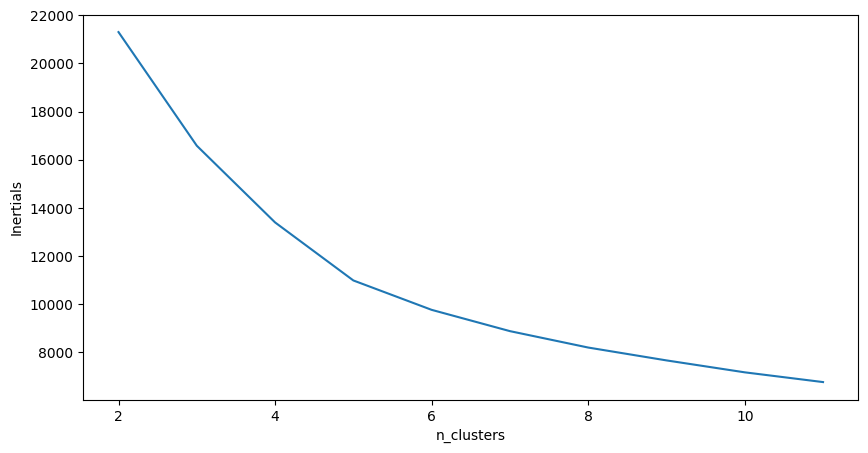

In [13]:

# Clustering
from sklearn.cluster import KMeans

k_vlaues = range(2, 12)
inertials = []

#we only do it for the accelerometer
#cluster_columns = ["x_acc", "y_acc", "z_acc"]
cluster_columns=['accelerationX', 'accelerationY',
       'accelerationZ']
for k in k_vlaues:
    subset = data[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertials.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_vlaues, inertials)
plt.xlabel("n_clusters")
plt.ylabel("Inertials")
plt.savefig('Clusters_elbow.png') 
plt.show()

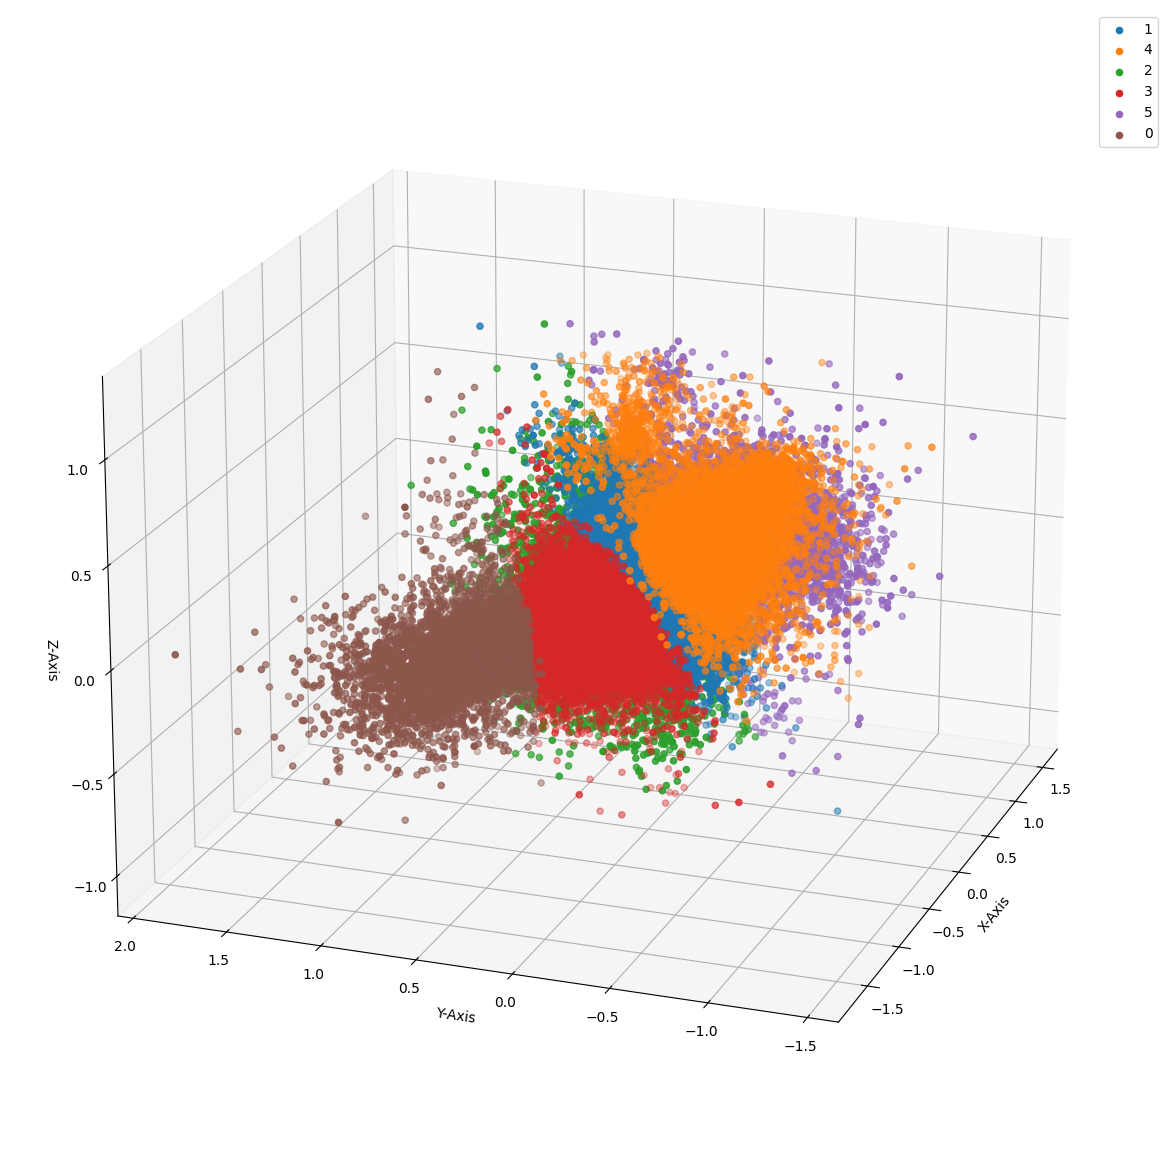

In [14]:
kmeans = KMeans(n_clusters=6, n_init=20, random_state=0)
subset = data[cluster_columns]
data["cluster"] = kmeans.fit_predict(subset)

# plot cluster
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")

for c in data["cluster"].unique():
    subset = data[data["cluster"] == c]
    ax.scatter(subset['accelerationX'], subset['accelerationY'], subset['accelerationZ'], label=c)

ax.set_xlabel("X-Axis")
ax.set_ylabel("Y-Axis")
ax.set_zlabel("Z-Axis")
ax.view_init(elev=20, azim=200) 
plt.legend()
plt.savefig('Clusters.png') 
plt.show()

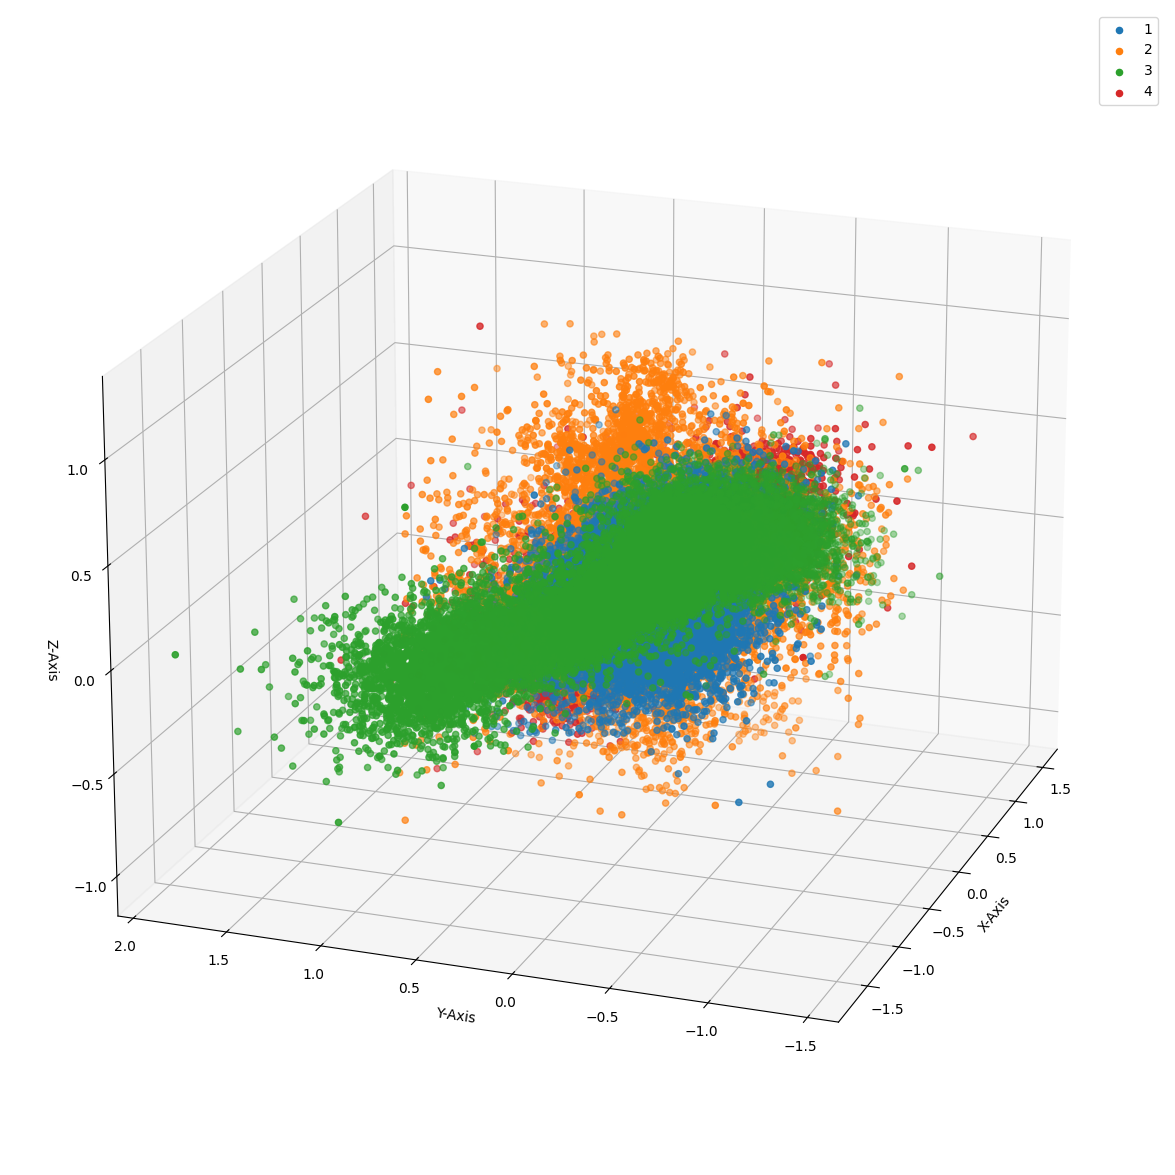

In [15]:

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")

for l in data["sport"].unique():
    subset = data[data["sport"] == l]
    ax.scatter(subset['accelerationX'], subset['accelerationY'], subset['accelerationZ'], label=l)

ax.set_xlabel("X-Axis")
ax.set_ylabel("Y-Axis")
ax.set_zlabel("Z-Axis")
# Set the viewing angle (elevation and azimuth)
ax.view_init(elev=20, azim=200)  # Adjust elev and azim for different views

plt.legend()
plt.savefig('Clusters_true.png') 
plt.show()

In [16]:
# We add all the features computed ( the clusters are already in 'data' )
data_full = pd.concat([data, principal_df[['PCA1','PCA2']],window5, window20, window100,frequency_features_df ], axis=1)
data_full=data_full.dropna()
data_full

,time,rotationRateX,rotationRateY,rotationRateZ,gravityX,gravityY,gravityZ,accelerationX,accelerationY,accelerationZ,...,z_acc_dominant_freq,z_acc_spectral_entropy,y_acc_dominant_freq,y_acc_spectral_entropy,x_acc_dominant_freq,x_acc_spectral_entropy,bpm_dominant_freq,bpm_spectral_entropy,sport_dominant_freq,sport_spectral_entropy
99,171829243922,0.008702,0.004451,-0.053711,0.250074,0.743829,-0.619823,0.010211,0.003287,0.014889,...,0.08,-898.398179,0.16,-169.587814,0.18,-45.370704,0.00,-0.000000,0.0,-0.0
100,171829243927,-0.041900,-0.013676,-0.039748,0.249034,0.744015,-0.620019,0.006414,-0.010357,0.002985,...,0.06,-1187.112990,0.12,-304.806051,0.18,-42.070148,0.00,-0.000000,0.0,-0.0
101,171829243932,-0.035148,-0.017830,-0.018111,0.248184,0.745646,-0.618399,-0.006378,0.008230,-0.014505,...,0.06,-1287.710856,0.12,-327.428317,0.18,-52.374114,0.00,0.205226,0.0,-0.0
102,171829243937,0.017548,-0.015216,-0.003710,0.247961,0.745757,-0.618355,0.013742,-0.001830,-0.013985,...,0.06,-1355.606502,0.12,-297.733907,0.18,-45.328373,0.00,-0.000000,0.0,-0.0
103,171829243942,-0.039274,-0.023545,0.018222,0.246873,0.746133,-0.618336,0.003051,-0.015145,0.010258,...,0.06,-1492.104214,0.12,-477.047415,0.18,-59.189818,0.02,-13.724500,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122756,171845325465,0.011509,0.004987,-0.103949,0.454161,-0.156195,-0.877121,-0.022810,0.011115,-0.014603,...,0.10,-857.765838,0.10,-1249.383700,0.36,-4324.682079,0.00,-0.000000,0.0,-0.0
122757,171845325470,0.041038,-0.017271,-0.114505,0.453735,-0.154562,-0.877630,-0.002884,0.017629,-0.013086,...,0.08,-535.109395,0.08,-1020.447443,0.36,-4746.167041,0.00,-0.000000,0.0,-0.0
122758,171845325475,0.023868,-0.034400,-0.103798,0.452458,-0.152908,-0.878579,0.018138,0.003280,-0.003455,...,0.36,-828.314371,0.08,-1141.573239,0.36,-3392.604410,0.00,-0.000000,0.0,-0.0
122759,171845325480,0.006906,-0.042538,-0.078482,0.451025,-0.150765,-0.879685,0.019159,-0.017066,0.006226,...,0.14,-1511.649695,0.10,-540.912578,0.36,-3782.723356,0.00,-0.000000,0.0,-0.0


In [17]:
data_full.columns

Index(['time', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX',
       'gravityY', 'gravityZ', 'accelerationX', 'accelerationY',
       'accelerationZ',
       ...
       'z_acc_dominant_freq', 'z_acc_spectral_entropy', 'y_acc_dominant_freq',
       'y_acc_spectral_entropy', 'x_acc_dominant_freq',
       'x_acc_spectral_entropy', 'bpm_dominant_freq', 'bpm_spectral_entropy',
       'sport_dominant_freq', 'sport_spectral_entropy'],
      dtype='object', length=127)

In [9]:
data.to_csv('raw_data_4_classes.csv', index=False)

In [18]:
data_full.to_csv('final_data_4_classes.csv', index=False)